In [1]:
import pickle

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from _BAR_estimator import get_values_from_trace
from _BAR_estimator import bayes_factor_smc
from _BAR_estimator import fit_normal_trace
from _BAR_estimator import draw_normal_samples
from _BAR_estimator import pot_ener_normal_aug
from _BAR_estimator import pot_ener
from _BAR_estimator import bootstrap_BAR
from _BAR_estimator import fit_uniform_trace
from _BAR_estimator import draw_uniform_samples
from _BAR_estimator import pot_ener_uniform_aug

In [2]:
SEED = 2039
SIZE = 50

SMC_STEPS = 20000
MET_STEPS = 100000

# Data Generation

In [3]:
def gaussian_mixture(mu1=0, sigma1=1, mu2=0, sigma2=1,
                     rho=0.5,
                     size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

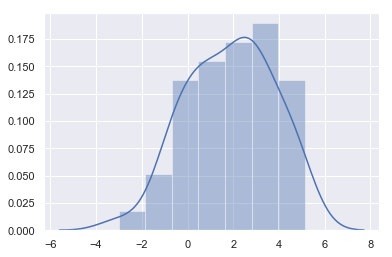

In [4]:
x = gaussian_mixture(mu1=0, sigma1=1, mu2=3, sigma2=1, rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1

In [5]:
with pm.Model() as model_m1:
    mu = pm.Uniform("mu", lower=-10, upper=10)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)

print(model_m1.vars)

[mu_interval__]


## Model 2

In [6]:
with pm.Model() as model_m2:
    w = pm.floatX([.5, .5])
    sigmas = pm.floatX([1., 1])
    
    mu = pm.Uniform("mu", lower=-10, upper=10)
    dmu = pm.Uniform("dmu", lower=0, upper=10)
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu)
    means = tt.set_subtensor(means[1], mu + dmu)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_m2.vars)

[mu_interval__, dmu_interval__]


# Sequential Monte Carlo

Sample initial stage: ...
Stage: 0 Beta: 0.003 Steps: 25
Stage: 1 Beta: 0.019 Steps: 5
Stage: 2 Beta: 0.142 Steps: 3
Stage: 3 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -59.81408


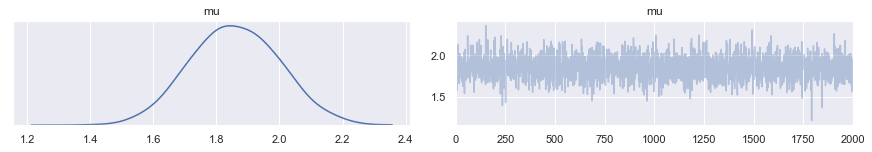

In [7]:
with model_m1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m1.marginal_likelihood)))

Sample initial stage: ...
Stage: 0 Beta: 0.006 Steps: 25
Stage: 1 Beta: 0.032 Steps: 8
Stage: 2 Beta: 0.090 Steps: 4
Stage: 3 Beta: 0.289 Steps: 5
Stage: 4 Beta: 0.983 Steps: 4
Stage: 5 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -47.13022


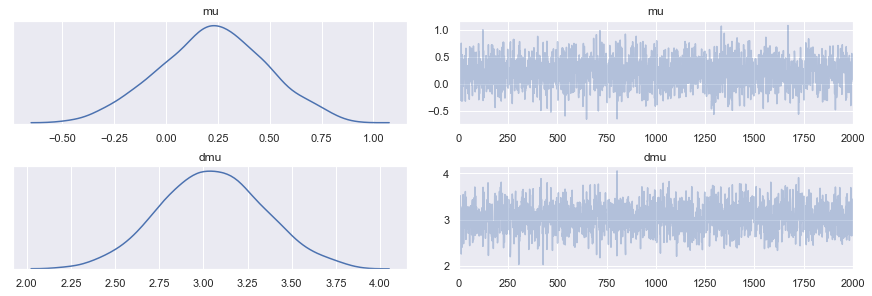

In [8]:
with model_m2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m2.marginal_likelihood)))

In [9]:
bf_smc_2_vs_1 = bayes_factor_smc(model_m1, model_m2)
print("Log10 of Bayes factor model m2 over model m1: %0.5f" % bf_smc_2_vs_1)

Log10 of Bayes factor model m2 over model m1: 12.68386


# BAR estimator

In [10]:
def bayes_factor_normal_aug(model_ini, sample_ini, model_fin, sample_fin, sigma_robust=False, bootstrap=None):
    
    mu_sigma_fin = fit_normal_trace(sample_fin, sigma_robust=sigma_robust)
    mu_sigma_fin = {"dmu_interval__": mu_sigma_fin["dmu_interval__"]}
    nsamples_ini = len(sample_ini["mu_interval__"])
    sample_aug_ini = draw_normal_samples(mu_sigma_fin, nsamples_ini)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_normal_aug(sample_ini, model_ini, sample_aug_ini, mu_sigma_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = sample_ini.copy()
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu_interval__": sample_fin["mu_interval__"]}
    sample_aug_fin = {"dmu_interval__": sample_fin["dmu_interval__"]}
    u_f_i = pot_ener_normal_aug(sample_fin_split, model_ini, sample_aug_fin, mu_sigma_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

In [11]:
def bayes_factor_uniform_aug(model_ini, sample_ini, model_fin, sample_fin, bootstrap=None):
    
    lower_upper_fin = fit_uniform_trace(sample_fin)
    lower_upper_fin = {"dmu_interval__": lower_upper_fin["dmu_interval__"]}
    nsamples_ini = len(sample_ini["mu_interval__"])
    sample_aug_ini = draw_uniform_samples(lower_upper_fin, nsamples_ini)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_uniform_aug(sample_ini, model_ini, sample_aug_ini, lower_upper_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = sample_ini.copy()
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu_interval__": sample_fin["mu_interval__"]}
    sample_aug_fin = {"dmu_interval__": sample_fin["dmu_interval__"]}
    u_f_i = pot_ener_uniform_aug(sample_fin_split, model_ini, sample_aug_fin, lower_upper_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

# Metropolis MC

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [00:35<00:00, 5625.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c235eb978>,
      dtype=object)

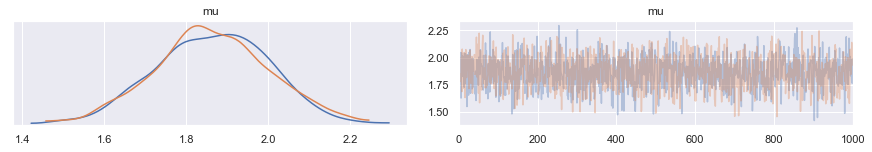

In [12]:
with model_m1:
    trace_m1 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m1[::100])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [dmu]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:15<00:00, 2671.14draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10167194e0>,
      dtype=object)

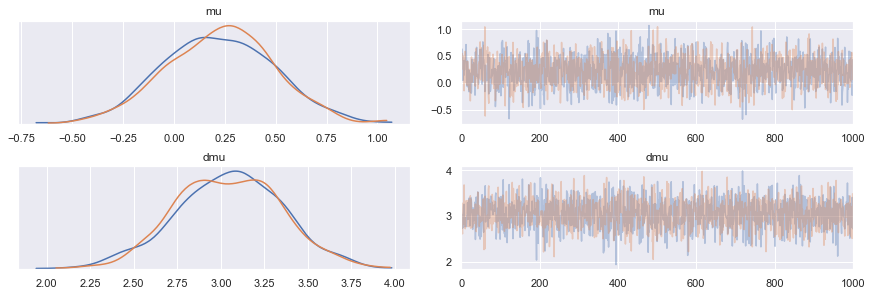

In [13]:
with model_m2:
    trace_m2 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m2[::100])

In [14]:
sample_m1 = get_values_from_trace(model_m1, trace_m1, thin=100, burn=1000)
sample_m2 = get_values_from_trace(model_m2, trace_m2, thin=100, burn=1000)

# Augmenting with normally-drawn samples

In [15]:
bayes_factor_normal_aug(model_m1, sample_m1, model_m2, sample_m2, sigma_robust=False, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.487
relative_change =        0.023
iteration     1: DeltaF =          -29.815
relative_change =        0.003
iteration     2: DeltaF =          -29.889
relative_change =        0.000
iteration     3: DeltaF =          -29.889
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 4 iterations (7 function evaluations)
DeltaF =  -29.889
Running 100 bootstraps to estimate error.
log10(bf) = 12.98079 +/- 0.39632


(29.88936316502915, 0.9125503271329333)

In [16]:
bayes_factor_normal_aug(model_m1, sample_m1, model_m2, sample_m2, sigma_robust=True, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.715
relative_change =        0.019
iteration     1: DeltaF =          -30.147
relative_change =        0.002
iteration     2: DeltaF =          -30.217
relative_change =        0.000
iteration     3: DeltaF =          -30.217
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 2.280903e-14 in 4 iterations (7 function evaluations)
DeltaF =  -30.217
Running 100 bootstraps to estimate error.
log10(bf) = 13.12319 +/- 0.36721


(30.217268706647136, 0.8455373838234622)

# Augmenting with uniformly-drawn samples

In [17]:
bayes_factor_uniform_aug(model_m1, sample_m1, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.966
relative_change =        0.019
iteration     1: DeltaF =          -30.379
relative_change =        0.002
iteration     2: DeltaF =          -30.443
relative_change =        0.000
iteration     3: DeltaF =          -30.443
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 1.948929e-14 in 4 iterations (7 function evaluations)
DeltaF =  -30.443
Running 100 bootstraps to estimate error.
log10(bf) = 13.22102 +/- 0.14546


(30.442526447242905, 0.33493824785633136)

# More aug samples per original sample

In [18]:
def repeat_sample(sample, repeats):
    sample = sample.copy()
    for k in sample.keys():
        sample[k] = np.repeat(sample[k], repeats)
    return sample

## Augmenting with normally-drawn samples

In [19]:
sample_m1_repeat = repeat_sample(sample_m1, 10)
bayes_factor_normal_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.680
relative_change =        0.044
iteration     1: DeltaF =          -29.379
relative_change =        0.004
iteration     2: DeltaF =          -29.501
relative_change =        0.000
iteration     3: DeltaF =          -29.501
relative_change =        0.000
iteration     4: DeltaF =          -29.501
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 0.000000e+00 in 5 iterations (8 function evaluations)
DeltaF =  -29.501
Running 100 bootstraps to estimate error.
log10(bf) = 12.81226 +/- 0.36342


(29.50131358669196, 0.8368066231178476)

In [20]:
sample_m1_repeat = repeat_sample(sample_m1, 20)
bayes_factor_normal_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.491
relative_change =        0.051
iteration     1: DeltaF =          -29.007
relative_change =        0.004
iteration     2: DeltaF =          -29.134
relative_change =        0.000
iteration     3: DeltaF =          -29.134
relative_change =        0.000
iteration     4: DeltaF =          -29.134
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 3.658324e-16 in 5 iterations (8 function evaluations)
DeltaF =  -29.134
Running 100 bootstraps to estimate error.
log10(bf) = 12.65271 +/- 0.35056


(29.133942303193294, 0.8071832216320053)

In [21]:
sample_m1_repeat = repeat_sample(sample_m1, 50)
bayes_factor_normal_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.611
relative_change =        0.056
iteration     1: DeltaF =          -28.993
relative_change =        0.005
iteration     2: DeltaF =          -29.138
relative_change =        0.000
iteration     3: DeltaF =          -29.138
relative_change =        0.000
iteration     4: DeltaF =          -29.138
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 5 iterations (8 function evaluations)
DeltaF =  -29.138
Running 100 bootstraps to estimate error.
log10(bf) = 12.65459 +/- 0.41484


(29.138271020200715, 0.9551972504298403)

In [22]:
sample_m1_repeat = repeat_sample(sample_m1, 100)
bayes_factor_normal_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.658
relative_change =        0.058
iteration     1: DeltaF =          -28.980
relative_change =        0.006
iteration     2: DeltaF =          -29.141
relative_change =        0.000
iteration     3: DeltaF =          -29.141
relative_change =        0.000
iteration     4: DeltaF =          -29.141
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 4.840086e-14 in 5 iterations (8 function evaluations)
DeltaF =  -29.141
Running 100 bootstraps to estimate error.
log10(bf) = 12.65558 +/- 0.40464


(29.140540492858104, 0.93171956872386)

## Augmenting with uniformly-drawn samples

In [23]:
sample_m1_repeat = repeat_sample(sample_m1, 10)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.871
relative_change =        0.047
iteration     1: DeltaF =          -29.495
relative_change =        0.004
iteration     2: DeltaF =          -29.604
relative_change =        0.000
iteration     3: DeltaF =          -29.604
relative_change =        0.000
iteration     4: DeltaF =          -29.604
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 0.000000e+00 in 5 iterations (8 function evaluations)
DeltaF =  -29.604
Running 100 bootstraps to estimate error.
log10(bf) = 12.85671 +/- 0.16163


(29.603665145369725, 0.3721755518127766)

In [24]:
sample_m1_repeat = repeat_sample(sample_m1, 20)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.892
relative_change =        0.055
iteration     1: DeltaF =          -29.271
relative_change =        0.004
iteration     2: DeltaF =          -29.380
relative_change =        0.000
iteration     3: DeltaF =          -29.380
relative_change =        0.000
iteration     4: DeltaF =          -29.380
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 2.418466e-16 in 5 iterations (8 function evaluations)
DeltaF =  -29.380
Running 100 bootstraps to estimate error.
log10(bf) = 12.75953 +/- 0.17865


(29.379893820305544, 0.4113677747271046)

In [25]:
sample_m1_repeat = repeat_sample(sample_m1, 50)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.712
relative_change =        0.066
iteration     1: DeltaF =          -28.813
relative_change =        0.003
iteration     2: DeltaF =          -28.914
relative_change =        0.000
iteration     3: DeltaF =          -28.914
relative_change =        0.000
iteration     4: DeltaF =          -28.914
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 9.829793e-16 in 5 iterations (8 function evaluations)
DeltaF =  -28.914
Running 100 bootstraps to estimate error.
log10(bf) = 12.55712 +/- 0.15807


(28.913842317909616, 0.3639596061438184)

In [26]:
sample_m1_repeat = repeat_sample(sample_m1, 100)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.571
relative_change =        0.074
iteration     1: DeltaF =          -28.456
relative_change =        0.003
iteration     2: DeltaF =          -28.540
relative_change =        0.000
iteration     3: DeltaF =          -28.540
relative_change =        0.000
iteration     4: DeltaF =          -28.540
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 1.867229e-15 in 5 iterations (8 function evaluations)
DeltaF =  -28.540
Running 100 bootstraps to estimate error.
log10(bf) = 12.39476 +/- 0.17052


(28.5399999563439, 0.39263514608767097)

In [27]:
sample_m1_repeat = repeat_sample(sample_m1, 500)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -30.207
relative_change =        0.089
iteration     1: DeltaF =          -27.726
relative_change =        0.002
iteration     2: DeltaF =          -27.769
relative_change =        0.000
iteration     3: DeltaF =          -27.769
relative_change =        0.000
iteration     4: DeltaF =          -27.769
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 5 iterations (8 function evaluations)
DeltaF =  -27.769
Running 100 bootstraps to estimate error.
log10(bf) = 12.05984 +/- 0.18388


(27.768798382695124, 0.42339314546802287)